https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-openpulse.html

In [95]:
#!pip uninstall  -q qiskit

Proceed (y/n)? y


In [1]:
!pip install -q --upgrade qiskit

     |████████████████████████████████| 8.3MB 4.6MB/s 
     |████████████████████████████████| 16.5MB 209kB/s 
     |████████████████████████████████| 163kB 51.6MB/s 
     |████████████████████████████████| 174kB 52.3MB/s 
     |████████████████████████████████| 1.9MB 40.5MB/s 
     |████████████████████████████████| 5.8MB 44.2MB/s 
     |████████████████████████████████| 962kB 44.7MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 296kB 48.9MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 583kB 37.3MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 2.7MB 45.7MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import seaborn as sns

from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib
from qiskit import assemble
from qiskit.tools.monitor import job_monitor

%matplotlib inline

import qiskit
qiskit.__qiskit_version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: the pulse_lib module is deprecated, pulse_lib is renamed to library
  # This is added back by InteractiveShellApp.init_path()


{'qiskit': None,
 'qiskit-aer': '0.6.1',
 'qiskit-aqua': '0.7.5',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-ignis': '0.4.0',
 'qiskit-terra': '0.15.1'}

In [3]:
with open('/content/drive/My Drive/ibmq.txt', 'r') as f:
   ibmq_api_key = f.readline()

IBMQ.save_account(ibmq_api_key)

In [4]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

/usr/local/lib/python3.6/dist-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


open pulseが使えるバックエンドか確認する。
現在使えるバックエンドは`ibmq_armonk`のみ（1qubit）

In [5]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [6]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [7]:
print(backend_config)

In [8]:
backend_defaults = backend.defaults()
print(backend_defaults)

<PulseDefaults(<InstructionScheduleMap(1Q instructions:
  q0: {'x', 'u1', 'id', 'u3', 'measure', 'u2'}
Multi qubit instructions:
)>Qubit Frequencies [GHz]
[4.974455810107823]
Measurement Frequencies [GHz]
[6.993427855] )>


In [9]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 10 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.974455810107823 GHz.
The sweep will go from 4.954455810107824 GHz to 4.994455810107824 GHz in steps of 10.0 MHz.


In [10]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [11]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                  # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In [12]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [13]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [14]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [15]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

In [16]:
#schedule_frequencies

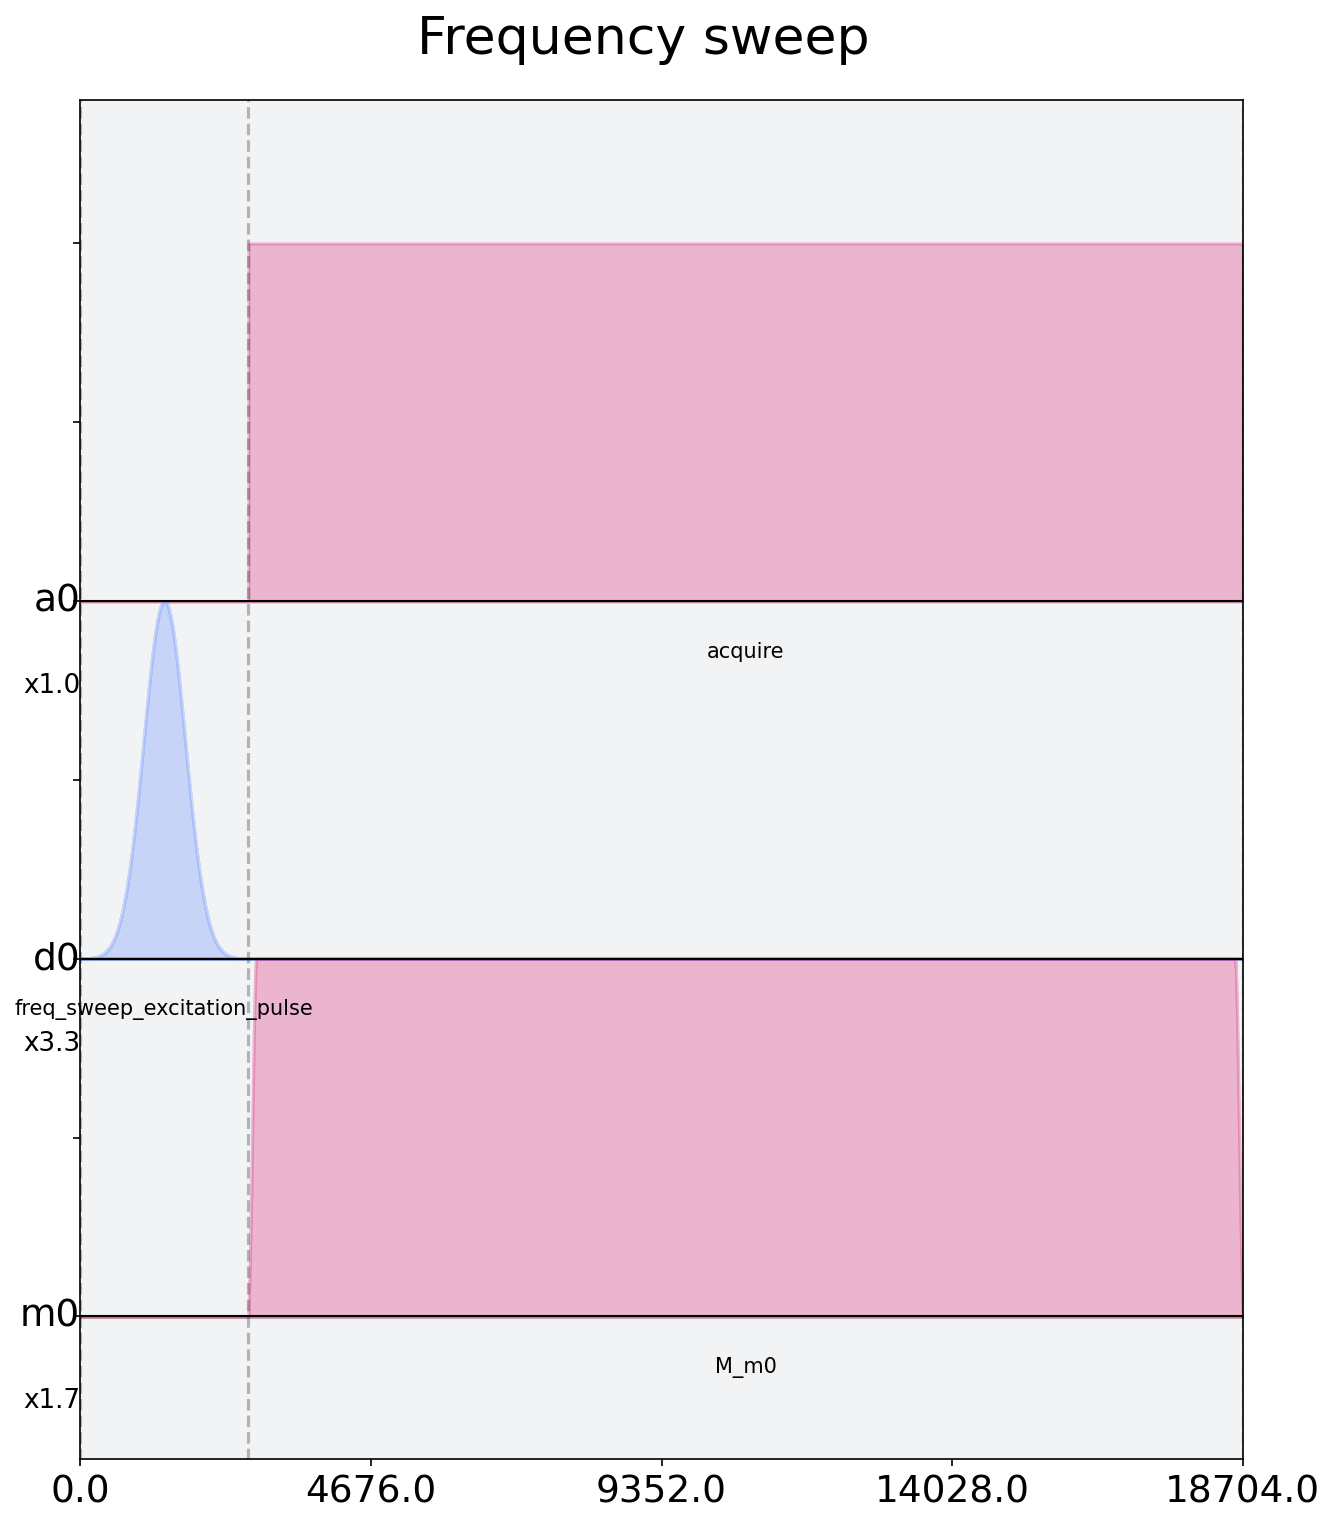

In [22]:
schedule.draw(label=True)

In [21]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

/usr/local/lib/python3.6/dist-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


In [28]:
job = backend.run(frequency_sweep_program)

In [29]:
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

5f33b3abd32e9300139c812f
Job Status: job has successfully run


In [30]:
job.error_message() 

In [31]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

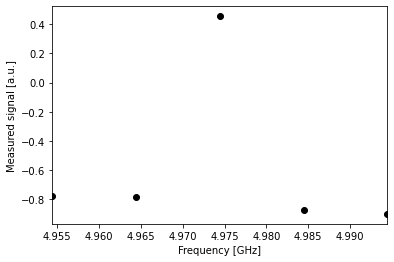

In [32]:
sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

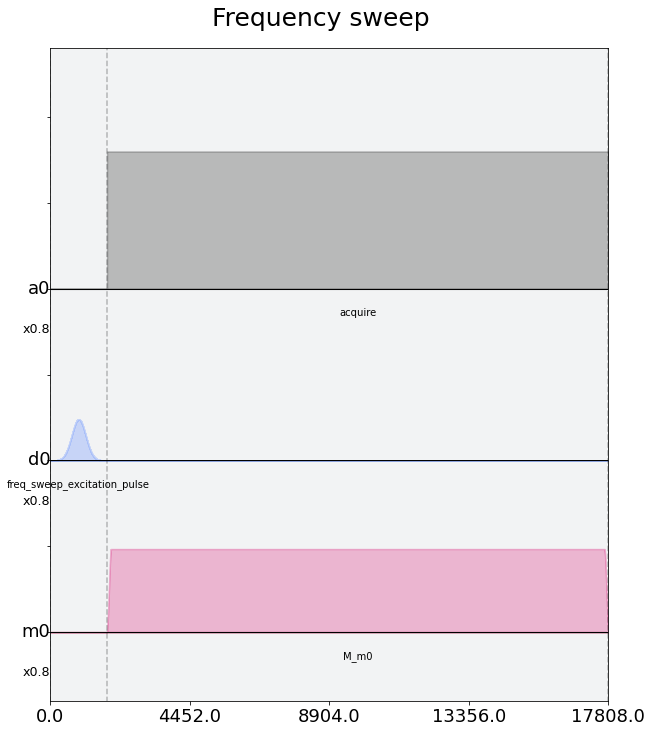

In [33]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.05
drive_samples_us = drive_sigma_us*8

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)      
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)  
drive_amp = 0.3
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)

schedule += measure << schedule.duration

frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

schedule.draw(label=True, scaling=0.8)

In [34]:
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

job = backend.run(frequency_sweep_program)

print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

5f33c12ac8af19001221444c
Job Status: job has successfully run


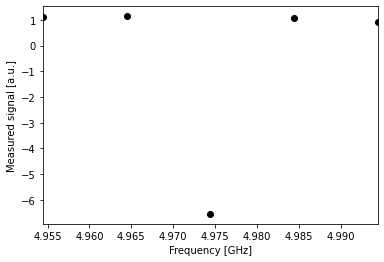

In [35]:
frequency_sweep_results = job.result(timeout=120)
sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [36]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [94]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.975, 0.5, 1] # initial parameters for curve_fit
                                )

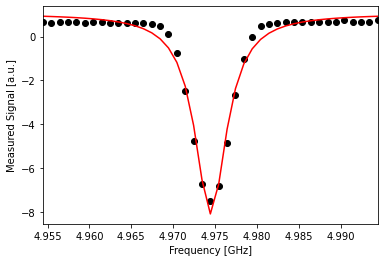

In [95]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [37]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

NameError: ignored

# πパルス

In [19]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [20]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

In [21]:
rabi_schedules[-1].draw(label=True, scaling=1.0)

TypeError: ignored

In [22]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

NameError: ignored

In [42]:
# print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

NameError: ignored

In [43]:
rabi_results = job.result(timeout=120)

In [23]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

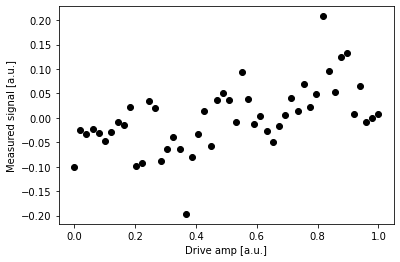

In [26]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

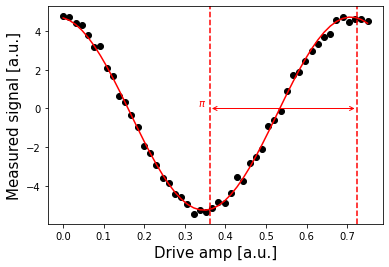

In [65]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [3, 0.1, 0.5, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [66]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.36162172838719725


In [24]:
num_rabi_points = 50

drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [ ]:
center_frequency_Hz = 4.97448*GHz
frequency_span_Hz = 15 * MHz
frequency_step_Hz = 0.5 * MHz
# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2

frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)
frequencies_Hz = frequencies_GHz*GHz

drive_sigma_us = 1                 # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)  

num_rabi_points = 75
# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 1
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

rabi_matrix = []
rabi_matrix_complex = []

for frq in frequencies_Hz:
    print(frq/GHz)
    rabi_schedules = []
    for drive_amp in drive_amps:
        #rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
        rabi_pulse = pulse_lib.constant(duration=drive_samples, amp=drive_amp, name=f"Rabi drive amplitude = {drive_amp}")
        this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
        this_schedule += Play(rabi_pulse, drive_chan)
        # Reuse the measure instruction from the frequency sweep experiment
        this_schedule += measure << this_schedule.duration
        rabi_schedules.append(this_schedule)

    num_shots_per_point = 512

    rabi_experiment_program = assemble(rabi_schedules,
                                      backend=backend,
                                      meas_level=1,
                                      meas_return='avg',
                                      shots=num_shots_per_point,
                                      schedule_los=[{drive_chan: frq}]
                                                    * num_rabi_points)
    
    job = backend.run(rabi_experiment_program)
    job_monitor(job)

    rabi_results = job.result(timeout=120)

    rabi_values = []
    for i in range(num_rabi_points):
        # Get the results for `qubit` from the ith experiment
        rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)
    
    rabi_matrix_complex.append(rabi_values)
    rabi_values = np.real(baseline_remove(rabi_values))

    rabi_matrix.append(rabi_values)

4.96698


/usr/local/lib/python3.6/dist-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


Job Status: job has successfully run
4.96748
Job Status: job has successfully run
4.96798
Job Status: job has successfully run
4.96848
Job Status: job has successfully run
4.968979999999999
Job Status: job has successfully run
4.969479999999999
Job Status: job has successfully run
4.969979999999999
Job Status: job has successfully run
4.9704799999999985
Job Status: job is queued (3)     

In [ ]:
sns.heatmap(rabi_matrix)

In [ ]:
plt.plot(rabi_matrix[1])

In [ ]:
sns.heatmap(np.abs(rabi_matrix_complex)-np.mean(np.abs(rabi_matrix_complex[1])), cmap='CMRmap')

In [ ]:
plt.plot(np.abs(rabi_matrix_complex[1])-np.mean(np.abs(rabi_matrix_complex[1])))

In [ ]:
import pandas as pd

df = pd.DataFrame(data=np.abs(rabi_matrix_complex), index=np.round(frequencies_GHz, 4), columns=np.round(drive_amps,2))

In [ ]:
sns.heatmap(df)

In [26]:
import numpy as np
from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

In [27]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# Mock Armonk backend
from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk


In [28]:
from qiskit.test.mock import FakeVigo

fake_backend = FakeVigo()
str(fake_backend.configuration())

'<qiskit.providers.models.backendconfiguration.QasmBackendConfiguration object at 0x7f718912efd0>'

In [29]:
armonk_backend = FakeArmonk()

In [30]:
print(armonk_backend.configuration())

In [31]:
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = 63455017.85

# set the qubit frequency
freq_est = 4.97e9
armonk_backend.defaults().qubit_freq_est = [freq_est]
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

In [32]:
armonk_backend.configuration().hamiltonian

{'description': 'Qubits are modeled as Duffing oscillators. In this case, the system includes higher energy states, i.e. not just |0> and |1>. The Pauli operators are generalized via the following set of transformations:\n\n$(\\mathbb{I}-\\sigma_{i}^z)/2 \\rightarrow O_i \\equiv b^\\dagger_{i} b_{i}$,\n\n$\\sigma_{+} \\rightarrow b^\\dagger$,\n\n$\\sigma_{-} \\rightarrow b$,\n\n$\\sigma_{i}^X \\rightarrow b^\\dagger_{i} + b_{i}$.\n\nQubits are coupled through resonator buses. The provided Hamiltonian has been projected into the zero excitation subspace of the resonator buses leading to an effective qubit-qubit flip-flop interaction. The qubit resonance frequencies in the Hamiltonian are the cavity dressed frequencies and not exactly what is returned by the backend defaults, which also includes the dressing due to the qubit-qubit interactions.\n\nQuantities are returned in angular frequencies, with units 2*pi*GHz.\n\nWARNING: Currently not all system Hamiltonian information is available

In [33]:
armonk_backend.defaults().qubit_freq_est

[4970000000.0]

In [34]:
armonk_model = PulseSystemModel.from_backend(armonk_backend)

In [35]:
qubits = [0]

# drive amplitudes to use
num_exps = 64
drive_amps = np.linspace(0, 1.0, num_exps)

# drive shape parameters
drive_duration = 2048
drive_sigma = 256

# list of drive channels
drive_channels = [DriveChannel(0)]

# construct the schedules
rabi_schedules, xdata = rabi_schedules(amp_list=drive_amps,
                                       qubits=qubits,
                                       pulse_width=drive_duration,
                                       pulse_sigma=drive_sigma,
                                       drives=drive_channels,
                                       inst_map=armonk_backend.defaults().instruction_schedule_map,
                                       meas_map=armonk_backend.configuration().meas_map)

In [36]:
backend_sim = PulseSimulator()

rabi_qobj = assemble(rabi_schedules,
                     backend=backend_sim,
                     meas_level=1,
                     meas_return='avg',
                     shots=512)

/usr/local/lib/python3.6/dist-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


In [37]:
sim_result = backend_sim.run(rabi_qobj, armonk_model).result()

Pi Amp: 0.200969


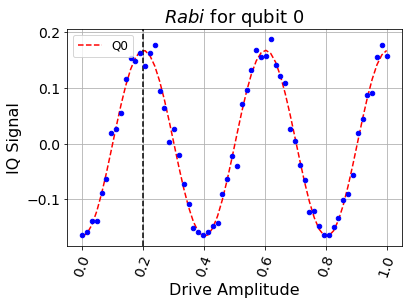

In [38]:
rabi_fit = RabiFitter(sim_result, xdata, qubits, fit_p0 = [1.5, 2, 0, 0])

# get the pi amplitude
pi_amp = rabi_fit.pi_amplitude(0)

# plot
rabi_fit.plot(0)
print('Pi Amp: %f'%pi_amp)

In [39]:
rabi_values = []
for i in range(num_exps):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(sim_result.get_memory(i)[0])

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


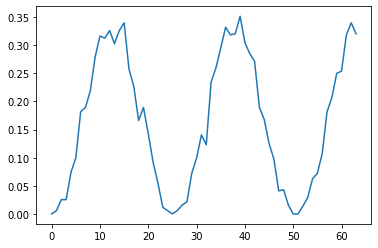

In [40]:
plt.plot(rabi_values)

In [41]:
num_rabi_points = 50

drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [42]:
center_frequency_Hz = 4.97448*GHz
frequency_span_Hz = 10 * MHz
frequency_step_Hz = 1 * MHz
# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2

frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)
frequencies_Hz = frequencies_GHz*GHz

drive_sigma_us = 0.5                 # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)  
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)  

num_rabi_points = 75
# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 1
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

rabi_matrix = []
rabi_matrix_complex = []

for frq in frequencies_Hz:
    print(frq/GHz)
    rabi_schedules = []
    for drive_amp in drive_amps:
        #rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
        rabi_pulse = pulse_lib.constant(duration=drive_samples, amp=drive_amp, name=f"Rabi drive amplitude = {drive_amp}")
        this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
        this_schedule += Play(rabi_pulse, drive_chan)
        # Reuse the measure instruction from the frequency sweep experiment
        this_schedule += measure << this_schedule.duration
        rabi_schedules.append(this_schedule)

    num_shots_per_point = 1024

    backend_sim = PulseSimulator()

    rabi_experiment_program = assemble(rabi_schedules,
                                      backend=backend_sim,
                                      meas_level=1,
                                      meas_return='avg',
                                      shots=num_shots_per_point,
                                      schedule_los=[{drive_chan: frq}]
                                                    * num_rabi_points)

    sim_result = backend_sim.run(rabi_experiment_program, armonk_model).result()

    rabi_values = []
    for i in range(num_rabi_points):
        # Get the results for `qubit` from the ith experiment
        rabi_values.append(sim_result.get_memory(i)[qubit])
    
    rabi_matrix_complex.append(rabi_values)
    rabi_values = np.real(baseline_remove(rabi_values))

    rabi_matrix.append(rabi_values)

4.96948


/usr/local/lib/python3.6/dist-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


4.97048


/usr/local/lib/python3.6/dist-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


4.971480000000001


/usr/local/lib/python3.6/dist-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


4.972480000000001


/usr/local/lib/python3.6/dist-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


4.973480000000001


/usr/local/lib/python3.6/dist-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


4.974480000000002


/usr/local/lib/python3.6/dist-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


4.975480000000002


/usr/local/lib/python3.6/dist-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


4.976480000000002


/usr/local/lib/python3.6/dist-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


4.977480000000003


/usr/local/lib/python3.6/dist-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


4.978480000000003


/usr/local/lib/python3.6/dist-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


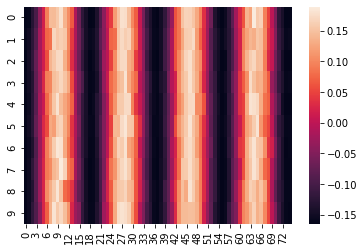

In [44]:
sns.heatmap(rabi_matrix)

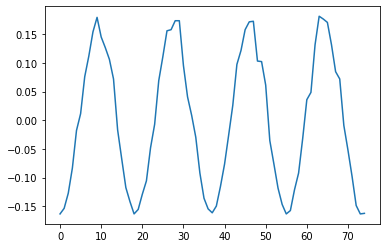

In [45]:
plt.plot(rabi_matrix[4])

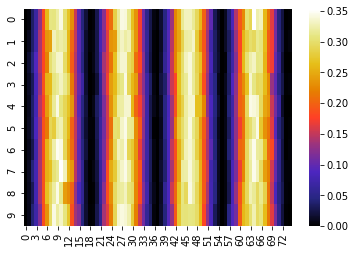

In [50]:
sns.heatmap(np.real(rabi_matrix_complex), cmap='CMRmap')